## **TML-Assignment 4 - Task 4**

## **Ahrar Bin Aslam and Muhammad Mubeen Siddiqui**

## **Comparing LIME and Grad-CAM Explanations on ImageNet Using ResNet50**

In [25]:
import os
import requests
import numpy as np
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
from lime import lime_image
from skimage.segmentation import mark_boundaries
from lime.wrappers.scikit_image import SegmentationAlgorithm
from sklearn.linear_model import Ridge
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.transform import resize

# Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
os.makedirs("imagenet_images", exist_ok=True)
os.makedirs("lime_outputs", exist_ok=True)

# ImageNet Sample URLs
image_urls = {
    "West_Highland_white_terrier": "https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n02098286_West_Highland_white_terrier.JPEG",
    "American_coot": "https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n02018207_American_coot.JPEG",
    "racer": "https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n04037443_racer.JPEG",
    "flamingo": "https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n02007558_flamingo.JPEG",
    "kite": "https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n01608432_kite.JPEG",
    "goldfish": "https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n01443537_goldfish.JPEG",
    "tiger_shark": "https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n01491361_tiger_shark.JPEG",
    "vulture": "https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n01616318_vulture.JPEG",
    "common_iguana": "https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n01677366_common_iguana.JPEG",
    "orange": "https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n07747607_orange.JPEG",
}

# Download Images
for name, url in image_urls.items():
    path = f"imagenet_images/{name}.jpeg"
    if not os.path.exists(path):
        r = requests.get(url)
        with open(path, 'wb') as f:
            f.write(r.content)

# Load pretrained ResNet50 model
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
model.eval().to(device)

# Data Preprocessing
def transform_for_lime(img):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])
    return transform(img).permute(1, 2, 0).numpy()

preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Predict on a batch of images (used by LIME)

def batch_predict(images):
    processed = []
    for img in images:
        if img.dtype != np.uint8:
            img = (img * 255).astype(np.uint8)
        img_pil = Image.fromarray(img)
        tensor = preprocess(img_pil)
        processed.append(tensor)
    batch = torch.stack(processed, dim=0).to(device)
    with torch.no_grad():
        logits = model(batch)
    return torch.nn.functional.softmax(logits, dim=1).cpu().numpy()

explainer = lime_image.LimeImageExplainer()

# Generate LIME explanations and masks
for name in image_urls:
    print(f"Explaining with LIME: {name}")
    img_path = f"imagenet_images/{name}.jpeg"
    pil_img = Image.open(img_path).convert('RGB')
    img_np = transform_for_lime(pil_img)
    input_tensor = preprocess(pil_img).unsqueeze(0).to(device)
    with torch.no_grad():
        pred = model(input_tensor)
    top_label = int(pred.argmax().item())
    hide_color = np.quantile(img_np, 0.2, axis=(0, 1)).astype(int).tolist()
    segmentation_fn = SegmentationAlgorithm('quickshift', kernel_size=5, max_dist=150, ratio=0.3)

    explanation = explainer.explain_instance(
        img_np,
        classifier_fn=batch_predict,
        labels=(top_label,),
        top_labels=1,
        num_features=10,
        num_samples=700,
        batch_size=10,
        segmentation_fn=segmentation_fn,
        distance_metric='cosine',
        model_regressor=Ridge(alpha=0.5),
        random_seed=42,
        hide_color=hide_color
    )

    temp, mask = explanation.get_image_and_mask(
        label=top_label,
        positive_only=True,
        num_features=10,
        hide_rest=False
    )

    np.save(f"lime_outputs/{name}_lime_mask.npy", mask.astype(np.uint8))
    temp_uint8 = (temp * 255).astype(np.uint8) if temp.dtype != np.uint8 else temp
    output_img = mark_boundaries(temp_uint8, mask)
    plt.imsave(f"lime_outputs/{name}_lime.png", output_img)

# Load and resize an image
def load_image(path, size=(224, 224)):
    img = imread(path)
    return resize(img, size, anti_aliasing=True)

# Convert Grad-CAM heatmap to binary mask using percentile threshold
def extract_gradcam_mask(gradcam_img, percentile=80):
    gray = rgb2gray(gradcam_img)
    threshold = np.percentile(gray, percentile)
    return (gray >= threshold).astype(np.uint8)

# Compute intersection-over-union between two binary masks
def compute_iou(mask1, mask2):
    intersection = np.logical_and(mask1, mask2).sum()
    union = np.logical_or(mask1, mask2).sum()
    return intersection / union if union != 0 else 0.0
    
# Plot and save visual comparison of original, masks, and their overlap
def visualize_and_save(original, gradcam_mask, lime_mask, name):
    fig, axs = plt.subplots(1, 4, figsize=(12, 4))
    axs[0].imshow(original)
    axs[0].set_title("Original")
    axs[1].imshow(gradcam_mask, cmap="hot")
    axs[1].set_title("Grad-CAM")
    axs[2].imshow(lime_mask, cmap="hot")
    axs[2].set_title("LIME")
    axs[3].imshow(gradcam_mask * lime_mask, cmap="hot")
    axs[3].set_title("Intersection")
    for ax in axs:
        ax.axis("off")
    plt.tight_layout()
    plt.savefig(f"iou_{name}.png")
    plt.close()

Explaining with LIME: West_Highland_white_terrier


  0%|          | 0/700 [00:00<?, ?it/s]

Explaining with LIME: American_coot


  0%|          | 0/700 [00:00<?, ?it/s]

Explaining with LIME: racer


  0%|          | 0/700 [00:00<?, ?it/s]

Explaining with LIME: flamingo


  0%|          | 0/700 [00:00<?, ?it/s]

Explaining with LIME: kite


  0%|          | 0/700 [00:00<?, ?it/s]

Explaining with LIME: goldfish


  0%|          | 0/700 [00:00<?, ?it/s]

Explaining with LIME: tiger_shark


  0%|          | 0/700 [00:00<?, ?it/s]

Explaining with LIME: vulture


  0%|          | 0/700 [00:00<?, ?it/s]

Explaining with LIME: common_iguana


  0%|          | 0/700 [00:00<?, ?it/s]

Explaining with LIME: orange


  0%|          | 0/700 [00:00<?, ?it/s]

## **IoU Comparison Between Grad-CAM and LIME Explanations**

In [26]:
def load_image(path, size=(224, 224)):
    img = imread(path)

    if img.shape[-1] == 4:
        img = img[..., :3]

    return resize(img, size, anti_aliasing=True)

print(" Comparing IoUs ")

# List to store (image_name, IoU score) pairs

ious = []

# Loop through each image name to compare LIME vs Grad-CAM masks
for name in image_urls:
    try:
        original = load_image(f"imagenet_images/{name}.jpeg")

        gradcam = load_image(f"/kaggle/input/grad-cam/{name}_cams.png")

        lime_mask = np.load(f"lime_outputs/{name}_lime_mask.npy")
        lime_mask = resize(lime_mask, (224, 224), order=0, preserve_range=True).astype(np.uint8)

        gradcam_mask = extract_gradcam_mask(gradcam)
        
        # Compute Intersection over Union between Grad-CAM and LIME masks
        
        iou = compute_iou(gradcam_mask, lime_mask)
        ious.append((name, iou))

        print(f"{name:<30} IoU: {iou:.4f}")
        visualize_and_save(original, gradcam_mask, lime_mask, name)

    except Exception as e:
        print(f"Failed on {name}: {e}")

# Compute average IoU across all processed images
avg = np.mean([v for _, v in ious])
print(f"Average IoU: {avg:.4f}")

 Comparing IoUs 
West_Highland_white_terrier    IoU: 0.1025
American_coot                  IoU: 0.1692
racer                          IoU: 0.1343
flamingo                       IoU: 0.1007
kite                           IoU: 0.1391
goldfish                       IoU: 0.0924
tiger_shark                    IoU: 0.1971
vulture                        IoU: 0.0790
common_iguana                  IoU: 0.1101
orange                         IoU: 0.0739
Average IoU: 0.1198


## **Visualization of the Intersection over Union Between LIME and Grad-CAM**

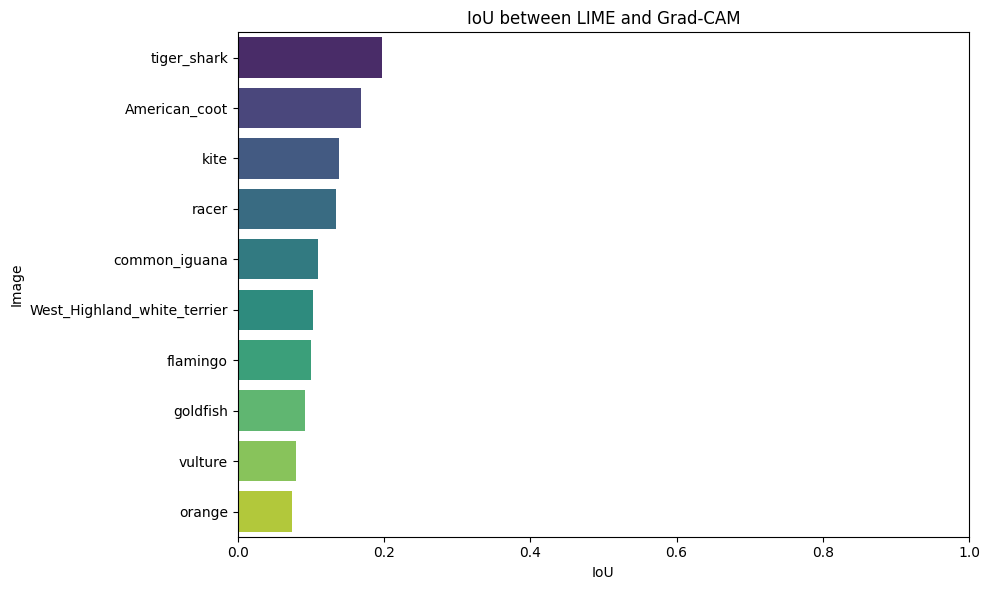

In [27]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

iou_df = pd.DataFrame(ious, columns=["Image", "IoU"]).sort_values("IoU", ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=iou_df, x="IoU", y="Image", palette="viridis")
plt.title("IoU between LIME and Grad-CAM")
plt.xlabel("IoU")
plt.ylabel("Image")
plt.xlim(0, 1)
plt.tight_layout()
plt.savefig("iou_bar_chart.png")
plt.show()

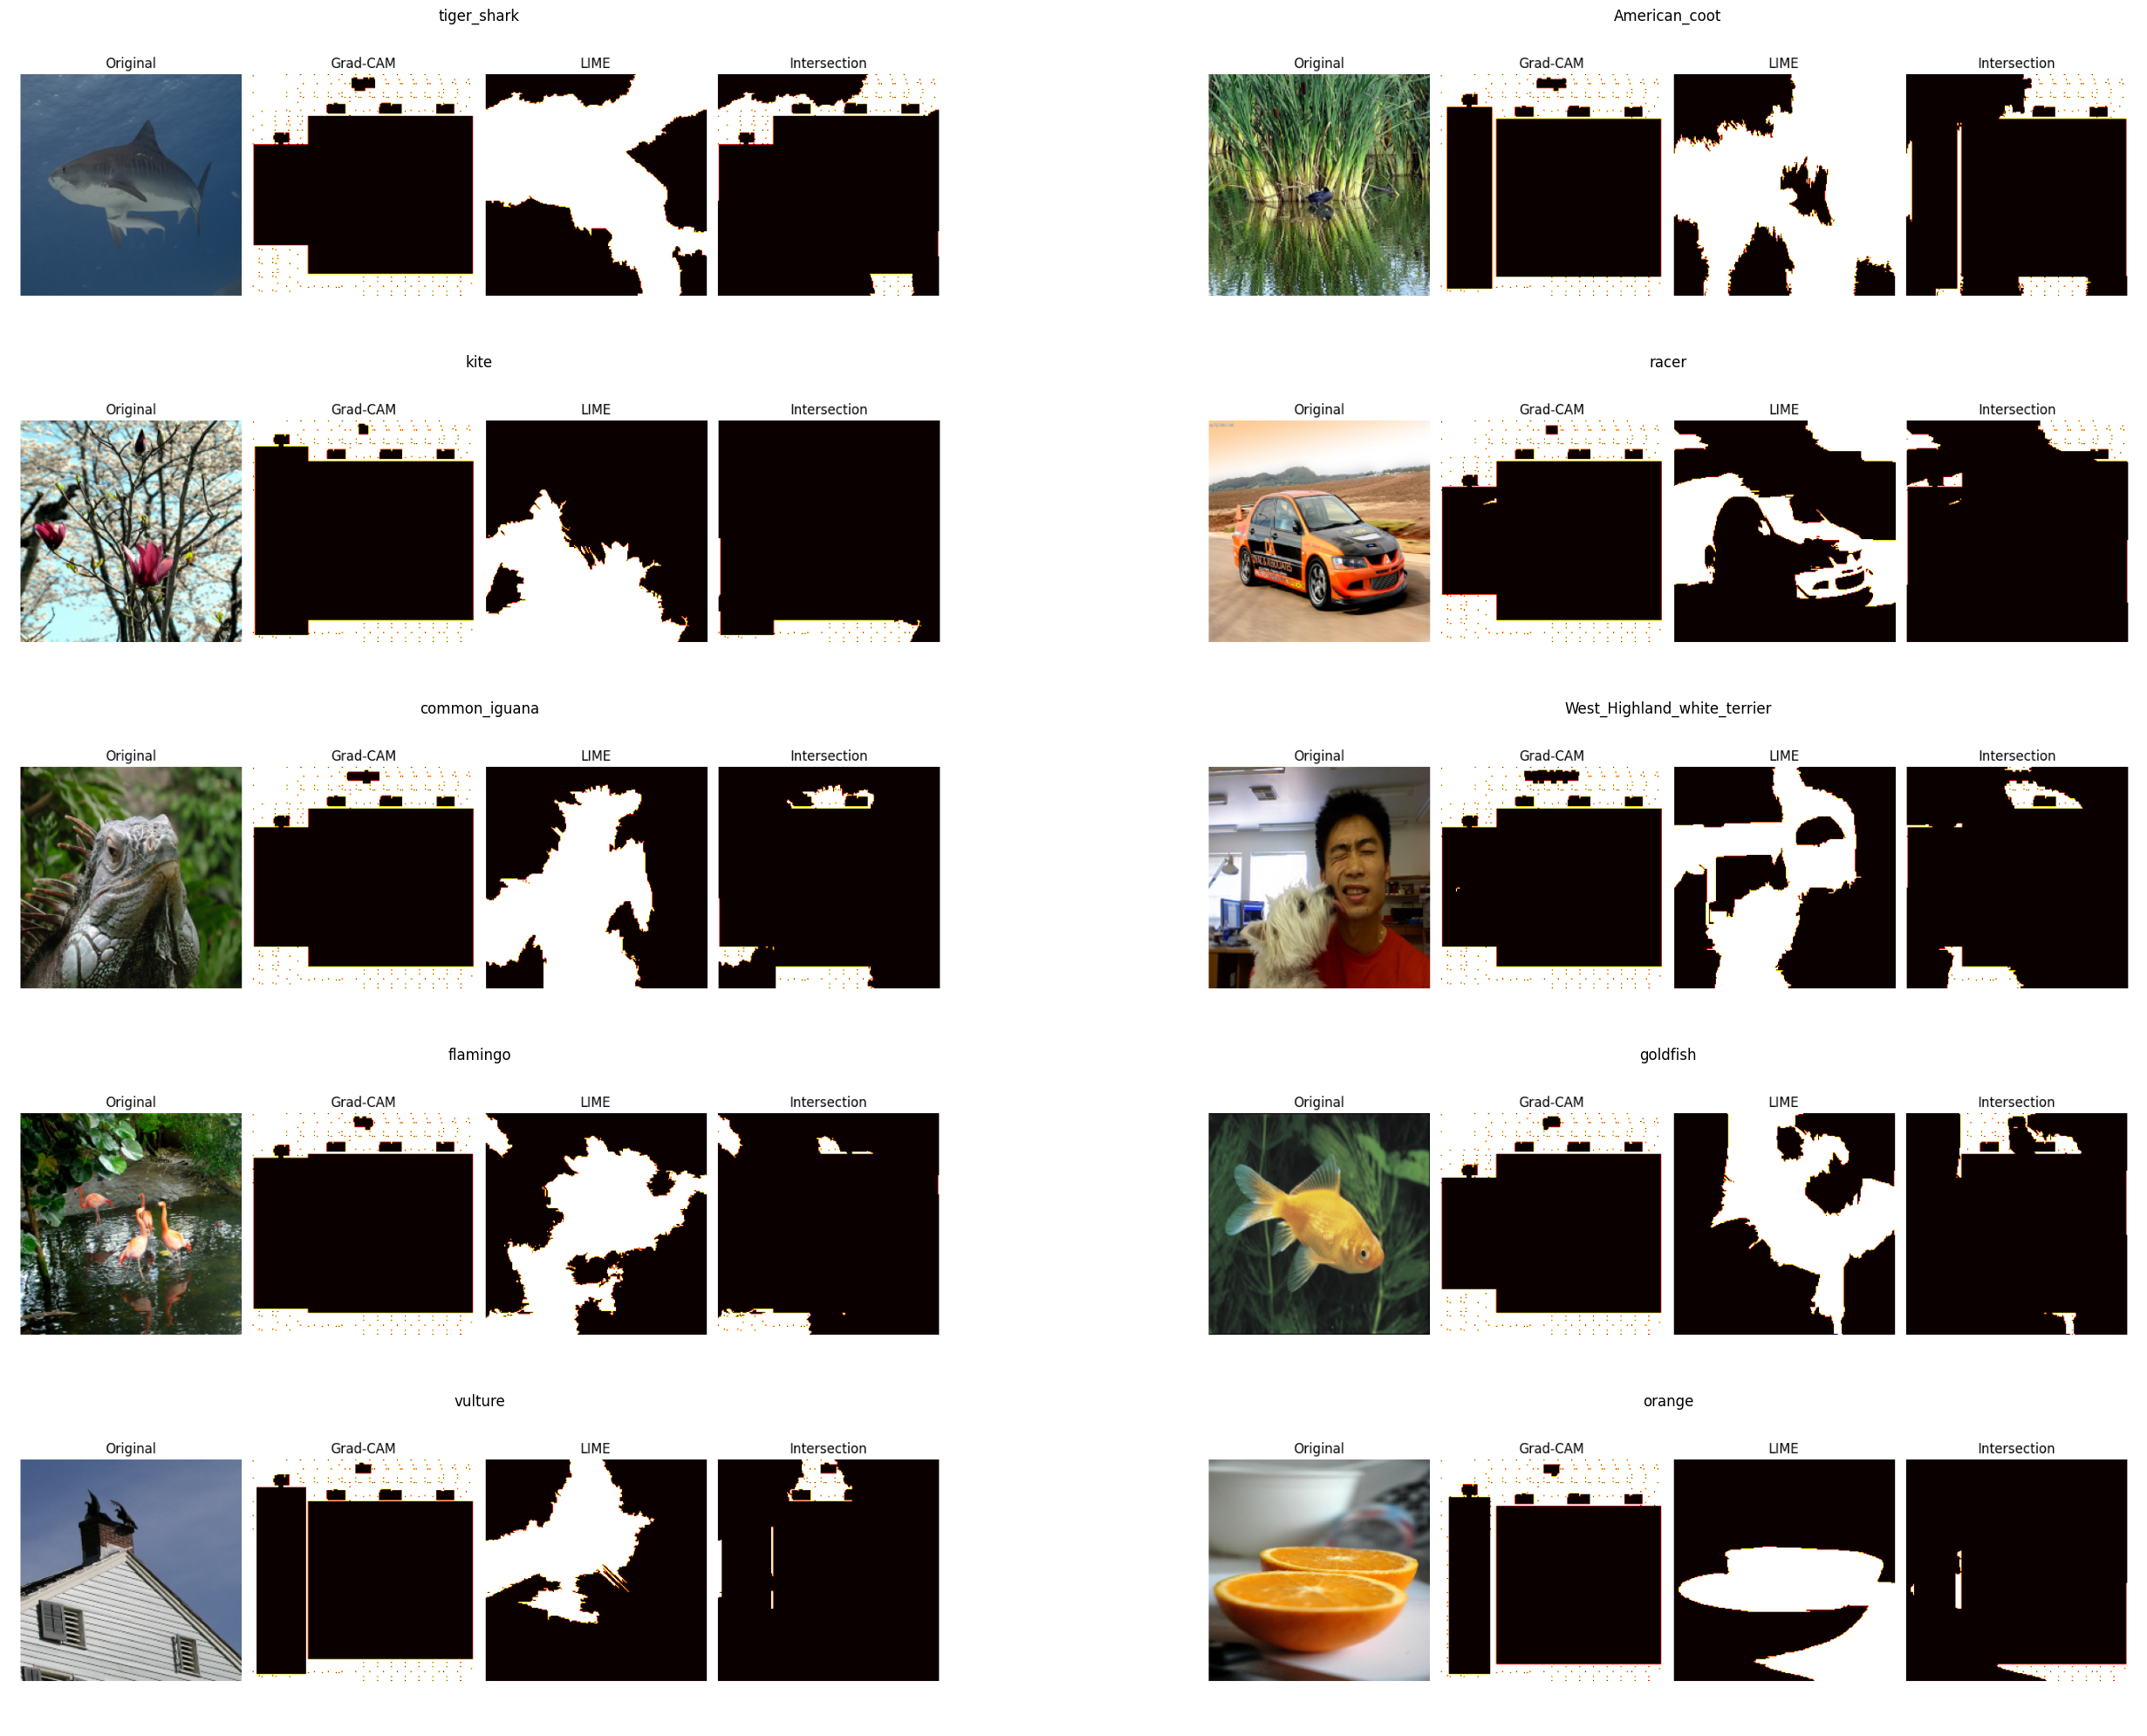

In [28]:
import matplotlib.image as mpimg

fig, axs = plt.subplots(5, 2, figsize=(30, 20))  # 2 rows × 5 images
axs = axs.flatten()

for i, (name, _) in enumerate(iou_df.values):
    img = mpimg.imread(f"iou_{name}.png")
    axs[i].imshow(img)
    axs[i].set_title(name)
    axs[i].axis('off')

plt.tight_layout()
plt.savefig("iou_grid.png")
plt.show()